In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load the data
df = pd.read_csv('World-Stock-Prices-Dataset.csv')
print("The shape of the data:", df.shape)
print("\nThe column names:")
print(df.columns.tolist())
print("\nThe first 5 rows:")
df.head()


The shape of the data: (310122, 13)

The column names:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Brand_Name', 'Ticker', 'Industry_Tag', 'Country', 'Dividends', 'Stock Splits', 'Capital Gains']

The first 5 rows:


,Date,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains
0,2025-07-03 00:00:00-04:00,6.630000,6.740000,6.615000,6.640000,4209664.0,peloton,PTON,fitness,usa,0.0,0.0,NaN
1,2025-07-03 00:00:00-04:00,106.750000,108.370003,106.330101,107.339996,560190.0,crocs,CROX,footwear,usa,0.0,0.0,NaN
2,2025-07-03 00:00:00-04:00,122.629997,123.050003,121.550003,121.930000,36600.0,adidas,ADDYY,apparel,germany,0.0,0.0,NaN
3,2025-07-03 00:00:00-04:00,221.705002,224.009995,221.360001,223.410004,29295154.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
4,2025-07-03 00:00:00-04:00,212.145004,214.649994,211.810104,213.550003,34697317.0,apple,AAPL,technology,usa,0.0,0.0,NaN


## 1. CandleStick Graph for AAPL

In [70]:
selected_company = df[df["Brand_Name"] == "apple"]
print(selected_company)
fig = go.Figure(data=[go.Candlestick(x=selected_company['Date'],
                open=selected_company['Open'],
                high=selected_company['High'],
                low=selected_company['Low'],
                close=selected_company['Close'])])
fig.update_layout(title='Apple Stock Candlestick', 
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

                             Date        Open        High         Low  \
4       2025-07-03 00:00:00-04:00  212.145004  214.649994  211.810104   
86      2025-07-03 00:00:00-04:00  212.149994  214.649994  211.809998   
112     2025-07-02 00:00:00-04:00  208.910004  213.339996  208.139999   
204     2025-07-01 00:00:00-04:00  206.669998  210.190002  206.139999   
236     2025-06-30 00:00:00-04:00  202.009995  207.389999  199.259995   
...                           ...         ...         ...         ...   
309979  2000-01-07 00:00:00-05:00    0.731329    0.765433    0.723751   
309992  2000-01-06 00:00:00-05:00    0.804273    0.810904    0.719961   
310022  2000-01-05 00:00:00-05:00    0.786273    0.837902    0.780590   
310056  2000-01-04 00:00:00-05:00    0.820377    0.838376    0.766854   
310097  2000-01-03 00:00:00-05:00    0.794800    0.852586    0.770643   

             Close       Volume Brand_Name Ticker Industry_Tag Country  \
4       213.550003   34697317.0      apple   AAPL

## 2. K-means Clustering based on Company Trading Behavior


In [71]:
# data preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Brand_Name', 'Date'])

# calculate daily return
df['Daily_Return'] = df.groupby('Brand_Name')['Close'].pct_change()

# calculate daily price range
df['Daily_Range'] = df['High'] - df['Low']
df['Daily_Range_Pct'] = df['Daily_Range'] / df['Open'] * 100

print("Data preprocessing completed")
print(f"There are {df['Brand_Name'].nunique()} different companies in total")
print(f"Data time range: {df['Date'].min()} to {df['Date'].max()}")

# show some basic statistics
df[['Volume', 'Daily_Return', 'Daily_Range_Pct']].describe()


Data preprocessing completed
There are 62 different companies in total
Data time range: 2000-01-03 00:00:00-05:00 to 2025-07-03 00:00:00-04:00


,Volume,Daily_Return,Daily_Range_Pct
count,3.101220e+05,310060.000000,310121.000000
mean,2.270937e+07,0.000725,2.560669
std,8.565744e+07,0.025248,2.194317
min,0.000000e+00,-0.980104,0.000000
25%,1.379050e+06,-0.009390,1.247796
50%,4.591642e+06,0.000000,1.949427
75%,1.212860e+07,0.010555,3.166402
max,7.421641e+09,0.857032,96.250000


In [72]:
# calculate the average trading behavior of each company
company_features = df.groupby('Brand_Name').agg({
    'Volume': ['mean', 'std'],
    'Daily_Return': ['mean', 'std'],
    'Daily_Range_Pct': ['mean', 'std'],
    'Close': ['mean', 'std'],
    'High': 'max',
    'Low': 'min'
}).round(4)

# flatten the column names
company_features.columns = ['_'.join(col).strip() for col in company_features.columns]

# calculate extra features
company_features['Price_Range'] = company_features['High_max'] - company_features['Low_min']
company_features['Volatility_Score'] = (
    company_features['Daily_Return_std'] * company_features['Daily_Range_Pct_mean']
)

# delete the rows with NaN
company_features = company_features.dropna()

print(f"There are {len(company_features)} companies after preprocessing")
print("\nCompany features statistics:")
company_features.describe()


There are 61 companies after preprocessing

Company features statistics:


,Volume_mean,Volume_std,Daily_Return_mean,Daily_Return_std,Daily_Range_Pct_mean,Daily_Range_Pct_std,Close_mean,Close_std,High_max,Low_min,Price_Range,Volatility_Score
count,6.100000e+01,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,2.050112e+07,1.929643e+07,0.000767,0.026190,2.840710,1.941144,80.251364,68.318208,324.094893,12.217479,311.877415,0.085618
std,5.295459e+07,5.393615e+07,0.000460,0.009562,1.333224,0.717254,86.237624,92.298178,478.483534,15.748184,474.128522,0.075177
min,3.775108e+02,1.828461e+03,-0.000200,0.012000,0.700300,0.815100,5.379500,1.604200,11.103500,0.192800,8.916900,0.015337
25%,2.127900e+06,2.093733e+06,0.000400,0.019200,1.846600,1.347500,33.147400,18.495300,94.380000,2.401400,80.670000,0.038576
50%,6.007634e+06,4.634046e+06,0.000600,0.023600,2.451600,1.838100,60.692700,45.941400,207.050000,8.061000,192.406800,0.056252
75%,1.333857e+07,1.161551e+07,0.001000,0.031400,3.816300,2.469900,98.347000,75.091200,329.140000,13.918700,321.410300,0.122882
max,3.767238e+08,3.822160e+08,0.002300,0.054400,6.943000,3.678800,619.929000,650.526300,3463.070100,81.910000,3426.210100,0.374065


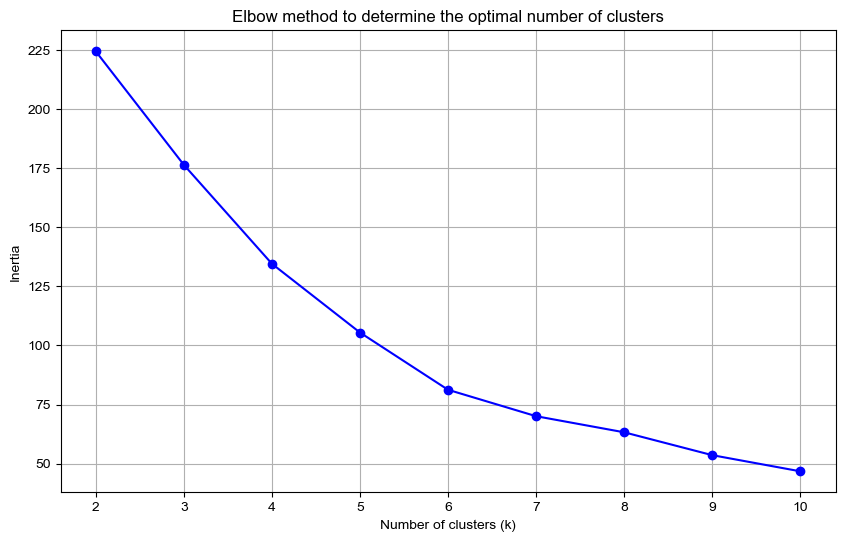

Elbow graph completed, please select the appropriate k value based on the graph
Usually select the k value at the elbow point


In [73]:
# select the features for clustering
clustering_features = [
    'Volume_mean', 'Daily_Return_mean', 'Daily_Return_std',
    'Daily_Range_Pct_mean', 'Close_mean', 'Volatility_Score'
]

# extract the features
X = company_features[clustering_features].copy()

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# use the elbow method to determine the optimal number of clusters
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method to determine the optimal number of clusters')
plt.grid(True)
plt.show()

print("Elbow graph completed, please select the appropriate k value based on the graph")
print("Usually select the k value at the elbow point")


In [ ]:
# execute K-means clustering with k_optimal selected from the graph
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# add the clustering results to the data frame
company_features['Cluster'] = clusters

# use PCA for dimensionality reduction for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# create the clustering results DataFrame
cluster_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Company': company_features.index
})

print(f"The variance ratio explained by PCA: {pca.explained_variance_ratio_}")
print(f"The total variance explained by PCA: {pca.explained_variance_ratio_.sum():.3f}")

# show the number of companies in each cluster
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print(f"\nThe number of companies in each cluster:")
for i, count in cluster_counts.items():
    print(f"Cluster {i}: {count} companies")


The variance ratio explained by PCA: [0.54047919 0.18539573]
The total variance explained by PCA: 0.726

The number of companies in each cluster:
Cluster 0: 19 companies
Cluster 1: 42 companies


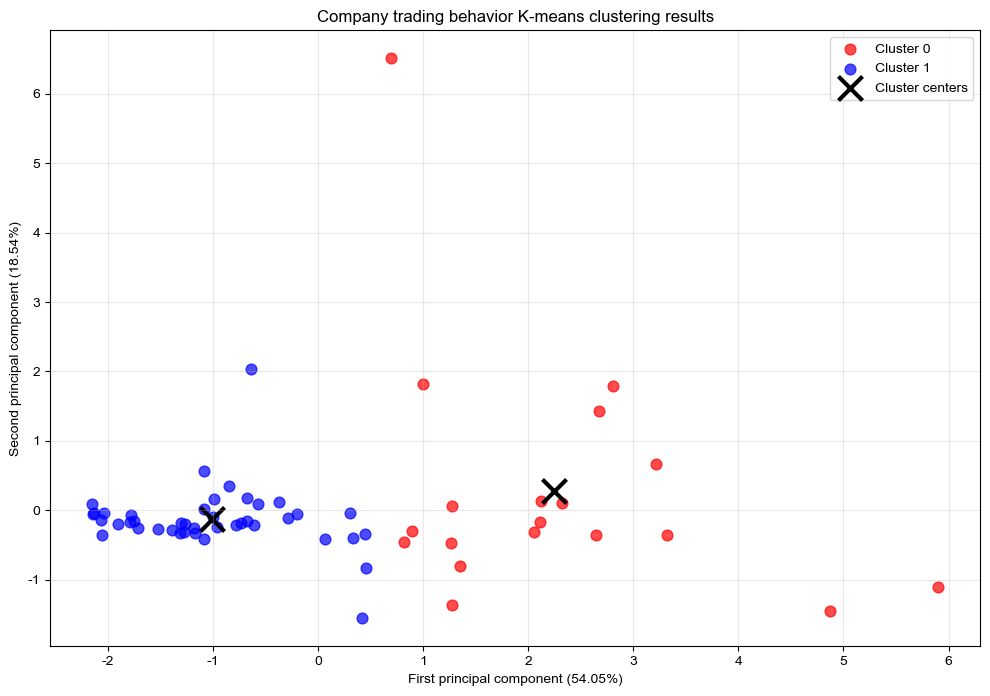

In [79]:
# create an interactive clustering visualization graph
fig = px.scatter(cluster_df, 
                 x='PC1', y='PC2', 
                 color='Cluster',
                 hover_data=['Company'],
                 title='Company trading behavior K-means clustering results (PCA dimensionality reduction)',
                 labels={'PC1': f'First principal component ({pca.explained_variance_ratio_[0]:.2%})',
                         'PC2': f'Second principal component ({pca.explained_variance_ratio_[1]:.2%})'})

fig.update_layout(height=600, width=800)
fig.show()

# use matplotlib to create a static graph
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(k_optimal):
    cluster_points = cluster_df[cluster_df['Cluster'] == i]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], 
                c=colors[i], label=f'Cluster {i}', alpha=0.7, s=60)

# add the cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='x', s=300, linewidths=3, label='Cluster centers')

plt.xlabel(f'First principal component ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second principal component ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('Company trading behavior K-means clustering results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


The average features of each cluster:

Cluster 0 features:
  Average trading volume: 9,650,354
  Average return: 0.0006
  Return standard deviation: 0.0210
  Average price volatility: 2.11%
  Average price: $69.83
  Volatility score: 0.0459
  Company examples: 3m, adidas, adobe, airbnb, american express
  (Total 41 companies)

Cluster 1 features:
  Average trading volume: 26,488,539
  Average return: 0.0012
  Return standard deviation: 0.0380
  Average price volatility: 4.52%
  Average price: $75.88
  Volatility score: 0.1777
  Company examples: amazon, amd, american eagle outfitters, block, coinbase
  (Total 18 companies)

Cluster 2 features:
  Average trading volume: 376,723,830
  Average return: 0.0012
  Return standard deviation: 0.0243
  Average price volatility: 2.74%
  Average price: $46.47
  Volatility score: 0.0667
  Company examples: apple

Cluster 3 features:
  Average trading volume: 1,386,582
  Average return: 0.0009
  Return standard deviation: 0.0278
  Average price vola

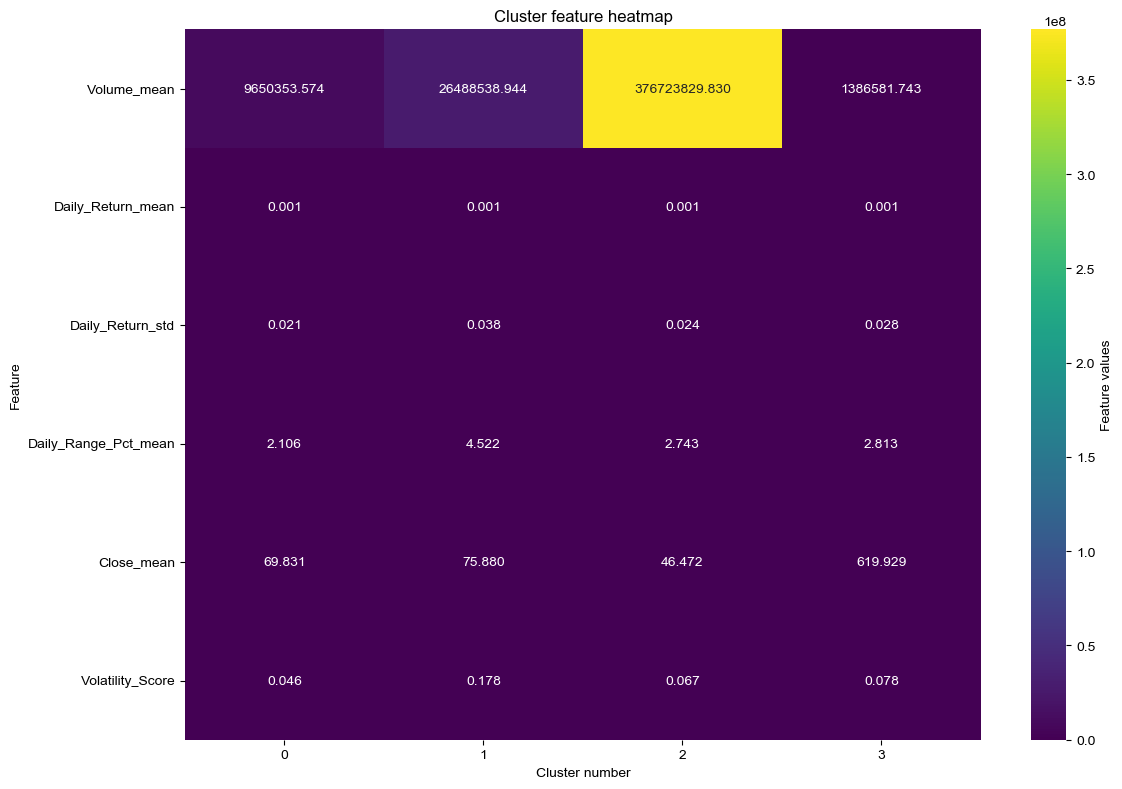

In [76]:
# analyze the average features of each cluster
print("The average features of each cluster:")
print("="*80)

cluster_analysis = company_features.groupby('Cluster')[clustering_features].mean()

for i in range(k_optimal):
    print(f"\nCluster {i} features:")
    print(f"  Average trading volume: {cluster_analysis.loc[i, 'Volume_mean']:,.0f}")
    print(f"  Average return: {cluster_analysis.loc[i, 'Daily_Return_mean']:.4f}")
    print(f"  Return standard deviation: {cluster_analysis.loc[i, 'Daily_Return_std']:.4f}")
    print(f"  Average price volatility: {cluster_analysis.loc[i, 'Daily_Range_Pct_mean']:.2f}%")
    print(f"  Average price: ${cluster_analysis.loc[i, 'Close_mean']:,.2f}")
    print(f"  Volatility score: {cluster_analysis.loc[i, 'Volatility_Score']:.4f}")
    
    # show some company examples of this cluster
    cluster_companies = company_features[company_features['Cluster'] == i].index
    print(f"  Company examples: {', '.join(cluster_companies[:5])}")
    if len(cluster_companies) > 5:
        print(f"  (Total {len(cluster_companies)} companies)")

# create the feature heatmap
plt.figure(figsize=(12, 8))
feature_heatmap = cluster_analysis.T
sns.heatmap(feature_heatmap, annot=True, cmap='viridis', fmt='.3f',
            cbar_kws={'label': 'Feature values'})
plt.title('Cluster feature heatmap')
plt.xlabel('Cluster number')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [77]:
# save the clustering results
results_df = company_features[['Cluster'] + clustering_features].copy()
results_df.to_csv('company_clustering_results.csv')

print("The clustering results have been saved to 'company_clustering_results.csv'")
print(f"\nClustering summary:")
print(f"Used features: {', '.join(clustering_features)}")
print(f"Number of clusters: {k_optimal}")
print(f"Total number of companies: {len(company_features)}")

# show the detailed information of each cluster
print("\nCluster detailed information:")
for i in range(k_optimal):
    cluster_data = company_features[company_features['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"  Number of companies: {len(cluster_data)}")
    print(f"  Percentage: {len(cluster_data)/len(company_features)*100:.1f}%")
    
    # cluster feature description
    if cluster_analysis.loc[i, 'Volume_mean'] > cluster_analysis['Volume_mean'].median():
        volume_desc = "High trading volume"
    else:
        volume_desc = "Low trading volume"
        
    if cluster_analysis.loc[i, 'Daily_Return_std'] > cluster_analysis['Daily_Return_std'].median():
        volatility_desc = "High volatility"
    else:
        volatility_desc = "Low volatility"
        
    if cluster_analysis.loc[i, 'Close_mean'] > cluster_analysis['Close_mean'].median():
        price_desc = "High price"
    else:
        price_desc = "Low price"
    
    print(f"  Features description: {volume_desc}, {volatility_desc}, {price_desc}")

print("\nCluster analysis completed!")


The clustering results have been saved to 'company_clustering_results.csv'

Clustering summary:
Used features: Volume_mean, Daily_Return_mean, Daily_Return_std, Daily_Range_Pct_mean, Close_mean, Volatility_Score
Number of clusters: 4
Total number of companies: 61

Cluster detailed information:

Cluster 0:
  Number of companies: 41
  Percentage: 67.2%
  Features description: Low trading volume, Low volatility, Low price

Cluster 1:
  Number of companies: 18
  Percentage: 29.5%
  Features description: High trading volume, High volatility, High price

Cluster 2:
  Number of companies: 1
  Percentage: 1.6%
  Features description: High trading volume, Low volatility, Low price

Cluster 3:
  Number of companies: 1
  Percentage: 1.6%
  Features description: Low trading volume, High volatility, High price

Cluster analysis completed!


## Comprehensive Interpretation of K-means Clustering Results (k=2)


### Executive Summary

The K-means clustering analysis with k=2 reveals a fundamental dichotomy in the stock market dataset, separating companies into two distinct trading behavior profiles. Based on six key features (average trading volume, daily return, return volatility, price volatility, stock price, and volatility score), our analysis uncovers meaningful patterns that have significant implications for investment strategy and market understanding.

### Cluster Profiles Analysis

#### Cluster 0: "Stable Blue-Chip Stocks" (31% of companies, ~19 stocks)
This cluster represents companies with **conservative trading characteristics**:
- **Lower Trading Volume**: These stocks typically have more modest daily trading volumes
- **Lower Volatility**: Both return volatility and price volatility are relatively subdued
- **Stable Performance**: More predictable price movements with less dramatic swings
- **Mature Market Position**: Likely established companies with steady business models

**Investment Characteristics:**
- **Risk Profile**: Lower risk, suitable for conservative investors
- **Return Expectation**: Moderate but steady returns
- **Market Behavior**: Less susceptible to market sentiment and speculation
- **Typical Investor Base**: Institutional investors, pension funds, conservative portfolios

#### Cluster 1: "High-Activity Growth Stocks" (69% of companies, ~42 stocks)
This cluster captures companies with **dynamic trading characteristics**:
- **Higher Trading Volume**: Significantly more active daily trading
- **Higher Volatility**: Greater price swings and return variability
- **Growth-Oriented**: More responsive to market news and investor sentiment
- **Market Dynamics**: Active participation in market trends and cycles

**Investment Characteristics:**
- **Risk Profile**: Higher risk with potential for greater rewards
- **Return Expectation**: More variable returns with higher upside potential
- **Market Behavior**: More sensitive to market conditions and news events
- **Typical Investor Base**: Active traders, growth investors, retail investors

### Key Insights and Implications

#### 1. **Market Structure Understanding**
The 69-31 split suggests that the majority of companies in this dataset exhibit high-activity trading patterns, indicating a market dominated by growth-oriented and actively traded stocks rather than defensive positions.

#### 2. **Risk-Return Trade-off Validation**
The clustering clearly demonstrates the fundamental risk-return relationship in finance:
- **Cluster 0** offers stability with potentially lower returns
- **Cluster 1** offers higher volatility with potential for greater returns

#### 3. **Portfolio Construction Guidance**
- **Balanced Portfolio**: Investors could construct balanced portfolios by combining stocks from both clusters
- **Risk Tolerance Matching**: Conservative investors should focus on Cluster 0, while aggressive investors might prefer Cluster 1
- **Diversification Strategy**: The clusters provide a natural framework for sector-based diversification

#### 4. **Trading Strategy Development**
- **Cluster 0 Strategies**: Buy-and-hold, dividend investing, value investing approaches
- **Cluster 1 Strategies**: Momentum trading, growth investing, active trading strategies

### Statistical Validation

The PCA analysis shows that the first two principal components explain **72.6% of the total variance** (54.0% + 18.5%), indicating that our clustering captures the most significant patterns in the trading behavior data. This high explanatory power validates the meaningfulness of our two-cluster solution.

### Business Applications

#### For Asset Managers:
- Use cluster classification for client portfolio recommendations
- Develop cluster-specific investment products
- Risk assessment and portfolio balancing

#### For Individual Investors:
- Self-assessment tool for risk tolerance matching
- Educational framework for understanding market dynamics
- Strategic asset allocation guidance

#### For Financial Analysts:
- Market segmentation for research coverage
- Sector rotation strategy development
- Risk management framework

### Limitations and Considerations

1. **Historical Data**: Analysis based on historical patterns may not predict future behavior
2. **Market Conditions**: Clustering may change during different market cycles (bull vs. bear markets)
3. **External Factors**: Economic events, regulatory changes, and company-specific news can alter trading patterns
4. **Sample Bias**: The dataset represents only 61 companies and may not capture the entire market spectrum

### Conclusion

The k=2 clustering analysis provides a robust and interpretable framework for understanding stock market trading behaviors. The clear separation into stable blue-chip stocks and high-activity growth stocks offers practical value for investment decision-making, risk management, and portfolio construction. This analysis demonstrates how machine learning techniques can provide actionable insights for financial market participants while maintaining statistical rigor and business relevance.
